# Create Bike Images with Wasserstein GAN

# BIKED Image Set

*Source: http://decode.mit.edu/projects/biked/*

**Image Set Properties:**
*    4510 manually-designed bicycle models
*    span all common bicycle styles and feature
*    unique models from remote corners
*    Image size: 1024 × 1024, RGB

**Changes**
*   Resize Images to 32x32, grayscale

**Bike Examples:**

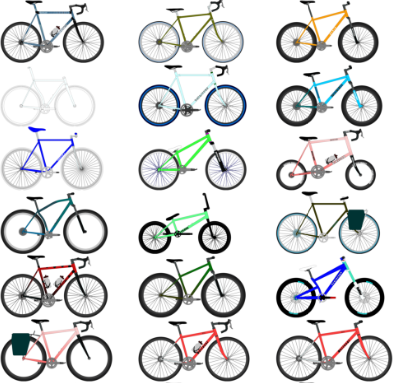

# Main Goals
*    Create New Bike Models with GAN

**Explanation:**

Use a Wasserstein GAN for:
*    stability training and
*    prevent mode collapse.

-> *GAN from Coursera Course C1W2 ended in Mode Collapse*
*(https://colab.research.google.com/drive/13OMpZuxHwuGdc4a7PWLHHPaC-MGeOgW9)*

## WGAN Model

**Used WGAN Model:**
*    In original a small WGAN for Predict MNIST Dataset digits in Google Colab
*  Modified for BIKED Dataset by myself
* Comment functions


***Sources:***

*1: https://colab.research.google.com/drive/12lFAHpVIVOHK8dVbZOlVxnMhFlfKnMND#scrollTo=2jpVpu8OYlky&uniqifier=1*

*2: https://bytepawn.com/training-a-pytorch-wasserstain-mnist-gan-on-google-colab.html*


### Packages and Librarys

In [ ]:
import os
import numpy as np
import math
import sys
from time import time
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import matplotlib.pyplot as plt
import warnings
###
from google.colab import drive
import time
from torchvision.datasets import ImageFolder
from time import time
from torchvision.utils import save_image

In [ ]:
warnings.filterwarnings('ignore')
#os.makedirs("images", exist_ok=True)

## Prepair small BIKED Dataset (32x32)

In [ ]:
##### Mount GDrive #####
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!rm -r /content/dataset/bike_klein2

In [ ]:
#### Copy Dataset to local drive #####
!mkdir dataset
!cp /content/gdrive/MyDrive/OpenCampus/GAN/bike_klein.zip dataset/bike_klein.zip
#!rm -r /content/bike_klein/
#time.sleep(2.0)
#### unzip ZIP Folder
!unzip -o -qq /content/dataset/bike_klein.zip -d /content/dataset/
#time.sleep(2.0)
!rm -r /content/dataset/__MACOSX
!rm -r /content/dataset/bike_klein.zip

### Model Options

In [ ]:
class Opt(object):
    dim = 10
    n_epochs = 200
    batch_size = dim*dim
    lr = 0.00005 #learning rate
    n_cpu = 1
    latent_dim = 100
    img_size = 32 #28
    channels = 1  #B/W
    n_critic = 5  #1
    clip_value = 0.01
    sample_interval = 100 #400

opt = Opt()  

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

## Generator Model

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

## Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(opt.img_size ** 2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
        
    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()


Generator:
```
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=1024, bias=True)
    (12): Tanh()
```
Discriminator
```
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)
```



In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),          #Add GrayScale Option
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [ ]:
transform

Compose(
    Grayscale(num_output_channels=1)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

## Load BIKED to Dataset

In [ ]:
#### Set Data direction
DATA_DIR = '/content/dataset/'
len(os.listdir(DATA_DIR + 'bike_klein'))

#### Create BIKED Image Dataset
# Use torch ImageFolder Function
dataset = ImageFolder(DATA_DIR, transform=transform)

In [ ]:
# Split Train, Test Set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Length testDataset
len(test_dataset)
len(train_dataset)

3608

In [ ]:
#Load local BIKED Data in torch DataLoader
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True)

## Optimizer

In [ ]:
# Optimizers
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)         #lr = 0.00005
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr) #lr = 0.00005

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## Training

In [ ]:
######################
## Training Options ##
# n_epochs: 200
# latent_dim: 100
# clip_value: 0.01
# n_critic: 5
######################

batches_done = 0
saved_imgs = []

# Epoch For-Loop
for epoch in range(opt.n_epochs):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()

    # Image For-Loop
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = Variable(imgs.type(Tensor))
        # train Discriminator
        discriminator_optimizer.zero_grad()     #gradients to zero
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim)))) #Noise Vector
        # generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        discriminator_loss = torch.mean(discriminator(fake_imgs)) - torch.mean(discriminator(real_imgs))
        discriminator_loss.backward()
        discriminator_optimizer.step()
        # clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)
        
        # train the generator every n_critic iterations
        if i % opt.n_critic == 0:               #n_critic:5
            # train Generator
            generator_optimizer.zero_grad()     #gradients to zero
            # generate a batch of fake images
            critics_fake_imgs = generator(z)
            # Adversarial loss
            generator_loss = -torch.mean(discriminator(critics_fake_imgs))
            generator_loss.backward()
            generator_optimizer.step()
        batches_done += 1
    
    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)

    # Save Image Samples in List
    grid = torchvision.utils.make_grid(critics_fake_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)


Epoch 0 training... done, took 4.1 seconds.
Epoch 1 training... done, took 1.7 seconds.
Epoch 2 training... done, took 1.6 seconds.
Epoch 3 training... done, took 1.6 seconds.
Epoch 4 training... done, took 1.5 seconds.
Epoch 5 training... done, took 1.6 seconds.
Epoch 6 training... done, took 1.5 seconds.
Epoch 7 training... done, took 1.6 seconds.
Epoch 8 training... done, took 1.6 seconds.
Epoch 9 training... done, took 1.5 seconds.
Epoch 10 training... done, took 1.5 seconds.
Epoch 11 training... done, took 1.6 seconds.
Epoch 12 training... done, took 1.6 seconds.
Epoch 13 training... done, took 1.9 seconds.
Epoch 14 training... done, took 1.5 seconds.
Epoch 15 training... done, took 1.5 seconds.
Epoch 16 training... done, took 1.5 seconds.
Epoch 17 training... done, took 1.5 seconds.
Epoch 18 training... done, took 1.5 seconds.
Epoch 19 training... done, took 1.5 seconds.
Epoch 20 training... done, took 1.6 seconds.
Epoch 21 training... done, took 1.6 seconds.
Epoch 22 training...

### Save Generator Model

In [ ]:
#model_path = '/content/gdrive/MyDrive/OpenCampus/GAN/model_save'
#torch.save(generator, model_path)
#the_model = torch.load("gen_model")


## Generated Images after 200 Epoches

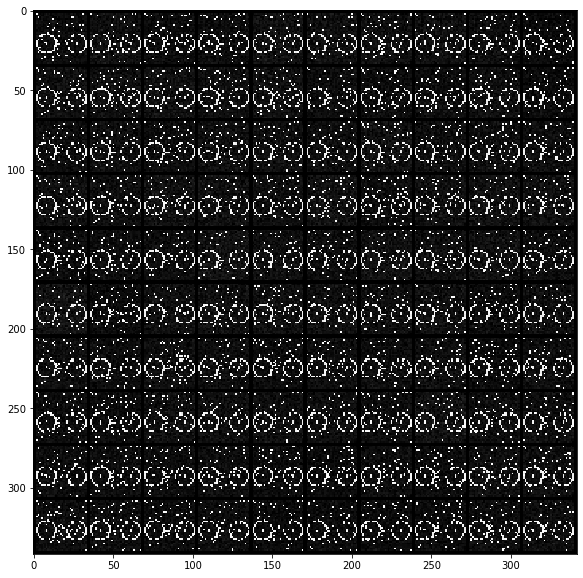

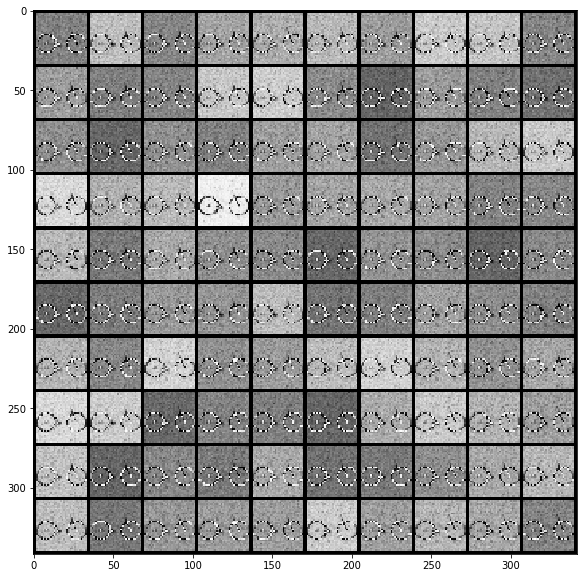

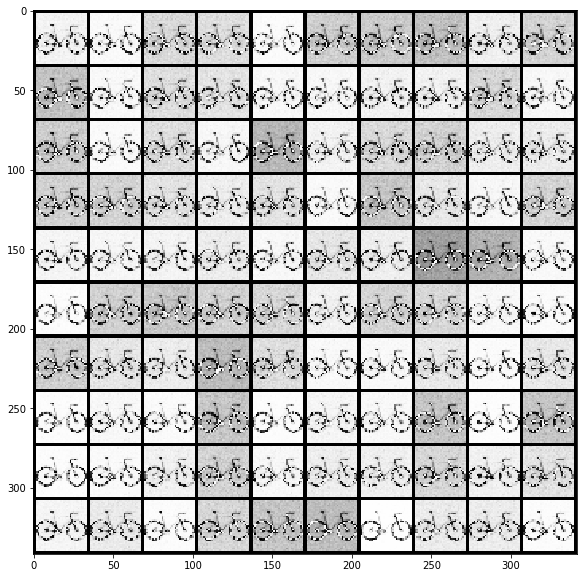

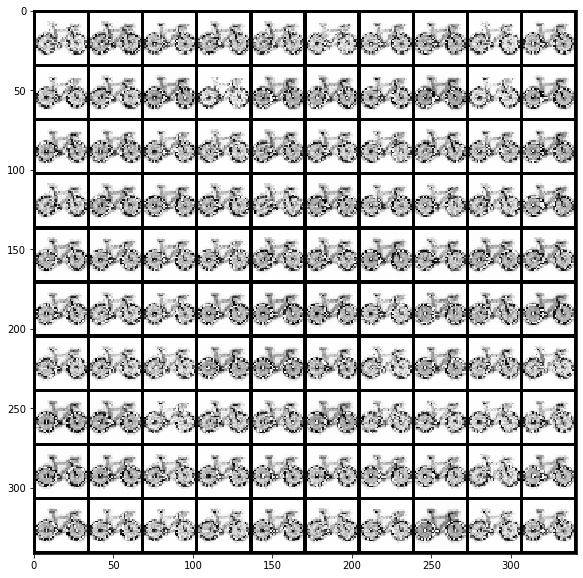

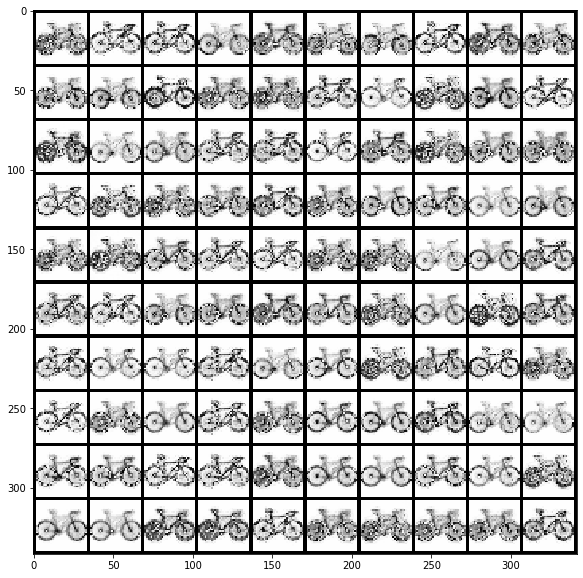

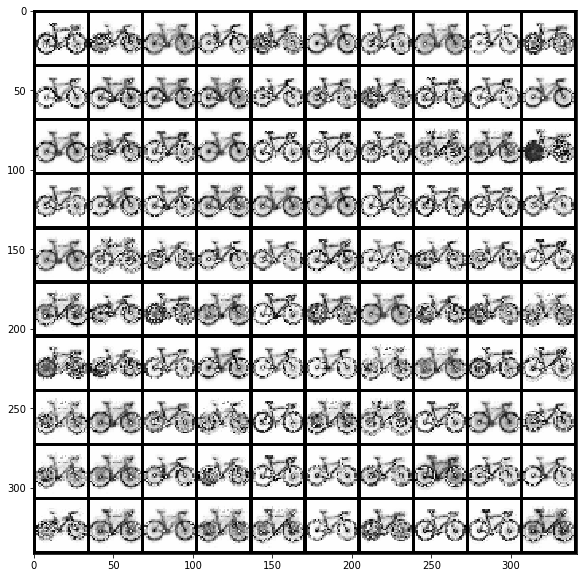

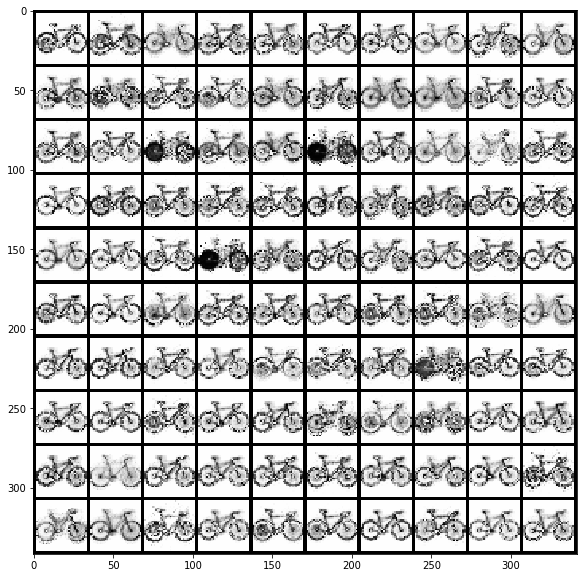

In [ ]:
img_indexes = [0, 4, 9, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))  # opt.dim = 10
    plt.imshow(saved_imgs[i], interpolation='nearest')

## Test Area

### Generator random images

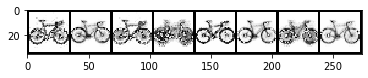

In [ ]:
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
# generate a batch of images
fake_imgs = generator(z).detach()
###
grid = torchvision.utils.make_grid(fake_imgs.data.cpu(), nrow=opt.dim)
img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
plt.imshow(img, interpolation='nearest')
###

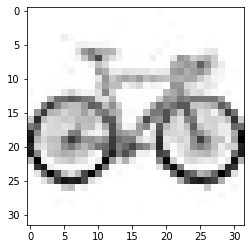

In [ ]:
p1 = fake_imgs[2].cpu().numpy() / 255.0
plt.imshow(p1[0], cmap='gray')

In [ ]:
r1 = real_imgs[4].cpu().numpy() / 255.0

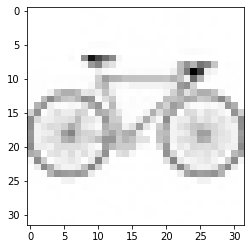

In [ ]:
plt.imshow(r1[0], cmap='gray')